In [1]:
from typing import List, Tuple, Dict, Union, Callable

import os
import sys
sys.path.append("..")

import multiprocessing as mp

import glob
import pathlib

import tqdm
tqdm.tqdm.pandas()

import json

import re

import numpy as np
import pandas as pd

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.misc import paths, utc_to_date
from src.topic import Top2VecViewer, generate_wordcloud
from src.classifiers import make_setfit_binary_predictor
from src.text import tokenize_text, normalize_text, text_to_sentences, get_similar_words_fasttext

## __Load Transcript Dataset__

In [2]:
class SEC10KLoader:

    def load(self):

        df_10k = pd.read_json(paths.item1a / "raw" / "item1a_full_scored_sents.json")
        df_10k.loc[:, "item1a_sentences"] = df_10k.loc[:, "item1a_sentences"].map(lambda ll: [s for l in ll for s in l])
        return df_10k
    
    def flush_processed(self, df: pd.DataFrame, name: str) -> pd.DataFrame:
        df.to_json(paths.item1a / "processed" / name, 
                   orient="records",
                   indent=4)
        return df
    
    def load_processed(self, name: str) -> pd.DataFrame:
        df = pd.read_json(paths.item1a / "processed" / name,
                          orient="records")
        return df


sec10k_loader = SEC10KLoader()

In [3]:
FROM_PROCESSED = False
if FROM_PROCESSED:
    df_10k = sec10k_loader.load_processed("item1a_with_attributes.json")
else:
    df_10k = sec10k_loader.load()
df_10k.head()

,symbol,filing_time,item1a,status,keywords,entities,noun_chunks,top8_key,top8_key_scr_all,top8_key_scr_avg,top8_key_scr_min,top8_ent,top8_ent_scr_all,top8_ent_scr_avg,top8_ent_scr_min,top8_nck,top8_nck_scr_all,top8_nck_scr_avg,top8_nck_scr_min,item1a_sentences
0,abml,2013-12-01,[The Risk Factors below are provided for a pot...,0,"[locate, think, call, lose, assurance, result,...","[oroplata, bylaw article incorporation, minist...","[government regulation, occasional spot shorta...","[accept, devote, hire, express, factor, achiev...","[24.00, 30.00, 3.00, 34.00, 8.00, 33.00, 17.00...",22.88,3,"[ministry mine, counter bulletin board, phase ...","[12.00, 2.00, 1.00, 2.00, 2.00, 2.00, 2.00, 16...",4.88,1,"[general economic political market condition, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00]",3.00,3,[The Risk Factors below are provided for a pot...
1,abml,2015-01-01,[The Risk Factors below are provided for a pot...,0,"[locate, lose, result, estimate, predict, slow...","[oroplata, mineral property, bylaw article inc...","[new mineral interest, material effect, near f...","[hire, factor, share, accept, express, devote,...","[3.00, 8.00, 17.00, 24.00, 34.00, 30.00, 41.00...",25.00,3,"[rule 3a51-1, leamary golf claim, mineral prop...","[2.00, 1.00, 1.00, 2.00, 2.00, 2.00, 2.00, 16.00]",3.50,1,"[cash need, commercially exploitable reserve, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 4.00]",3.12,3,[The Risk Factors below are provided for a pot...
2,abml,2015-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,"[operating agreement, ontario superior court, ...","[368.00, 368.00, 368.00, 368.00, 30.00, 368.00...",325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...
3,abml,2016-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,"[operating agreement, ontario superior court, ...","[368.00, 368.00, 368.00, 368.00, 30.00, 368.00...",325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...
4,abml,2018-01-01,[Not required..],0,[require],[],[],"[penetrate, pay, perceive, require, permit, pe...","[368.00, 368.00, 368.00, 352.00, 368.00, 368.0...",366.00,352,"[operating agreement northern comstock, opec, ...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,"[party site, party source, party processing ac...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,[Not required..]


## __Assign Attributes to Earning's Call Transcripts__

### __Get Topic IDs__

In [20]:
# This global variable is also used in the `compute_statistics` function
topic_stoi_cluster = {
    "environmental_regulation": 2,
    "customer_orientation":     4,
    "shareholder_affiliation":  6,
    "hiring_employees":         8,
    "natural_disaster":         9,
    "litigation":               11,
    "carbon_emissions":         12,
    "labor_issues":             13,
    "supply_chain_problems":    14,
    "taxes":                    15
}
topic_stoi_pillar = {
    "environmental": 0,
    "social":        1,
    "governance":    2,
}

topic_itos_cluster = {v: k for k, v in topic_stoi_cluster.items()}
topic_itos_pillar = {v: k for k, v in topic_stoi_pillar.items()}

id_map_cluster = list(topic_itos_cluster.keys())
id_map_pillar = list(topic_itos_pillar.keys())

In [5]:
t2v_viewer = Top2VecViewer.load(paths.t2v / "doc2vec-deep-learn-16-topics.pkl")

# Pair topic words with their scores
#   We will trim the topic words to keep only the relevant
#   ones for the topic using domain knowledge
topic_words = t2v_viewer.get_topic_words(topic_itos_cluster.keys(), top_k=25)
topic_words.loc[:, "topic_name"] = topic_words["topic_num"].map(lambda i: topic_itos_cluster[i])
topic_words.head()

,topic_num,keyword,cosine_score,topic_name
0,2,regulation,0.4565,environmental_regulation
1,2,stringent,0.4128,environmental_regulation
2,2,environmental,0.3880,environmental_regulation
3,2,law,0.3719,environmental_regulation
4,2,hazardous,0.3663,environmental_regulation


In [6]:
# Load trimmed topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_aj_th.csv")
topic_words = topic_words.loc[topic_words["suggest_delete_any"] != 1]
topic_words.head()

,topic_num,keyword,suggest_delete_anne,suggest_delete_tony,suggest_delete_any,suggest_delete_both,cosine_score,topic_name
0,2,regulation,NaN,NaN,NaN,NaN,0.4565,environmental_regulation
2,2,environmental,NaN,NaN,NaN,NaN,0.3880,environmental_regulation
3,2,law,NaN,NaN,NaN,NaN,0.3719,environmental_regulation
4,2,hazardous,NaN,NaN,NaN,NaN,0.3663,environmental_regulation
5,2,waste,NaN,NaN,NaN,NaN,0.3608,environmental_regulation


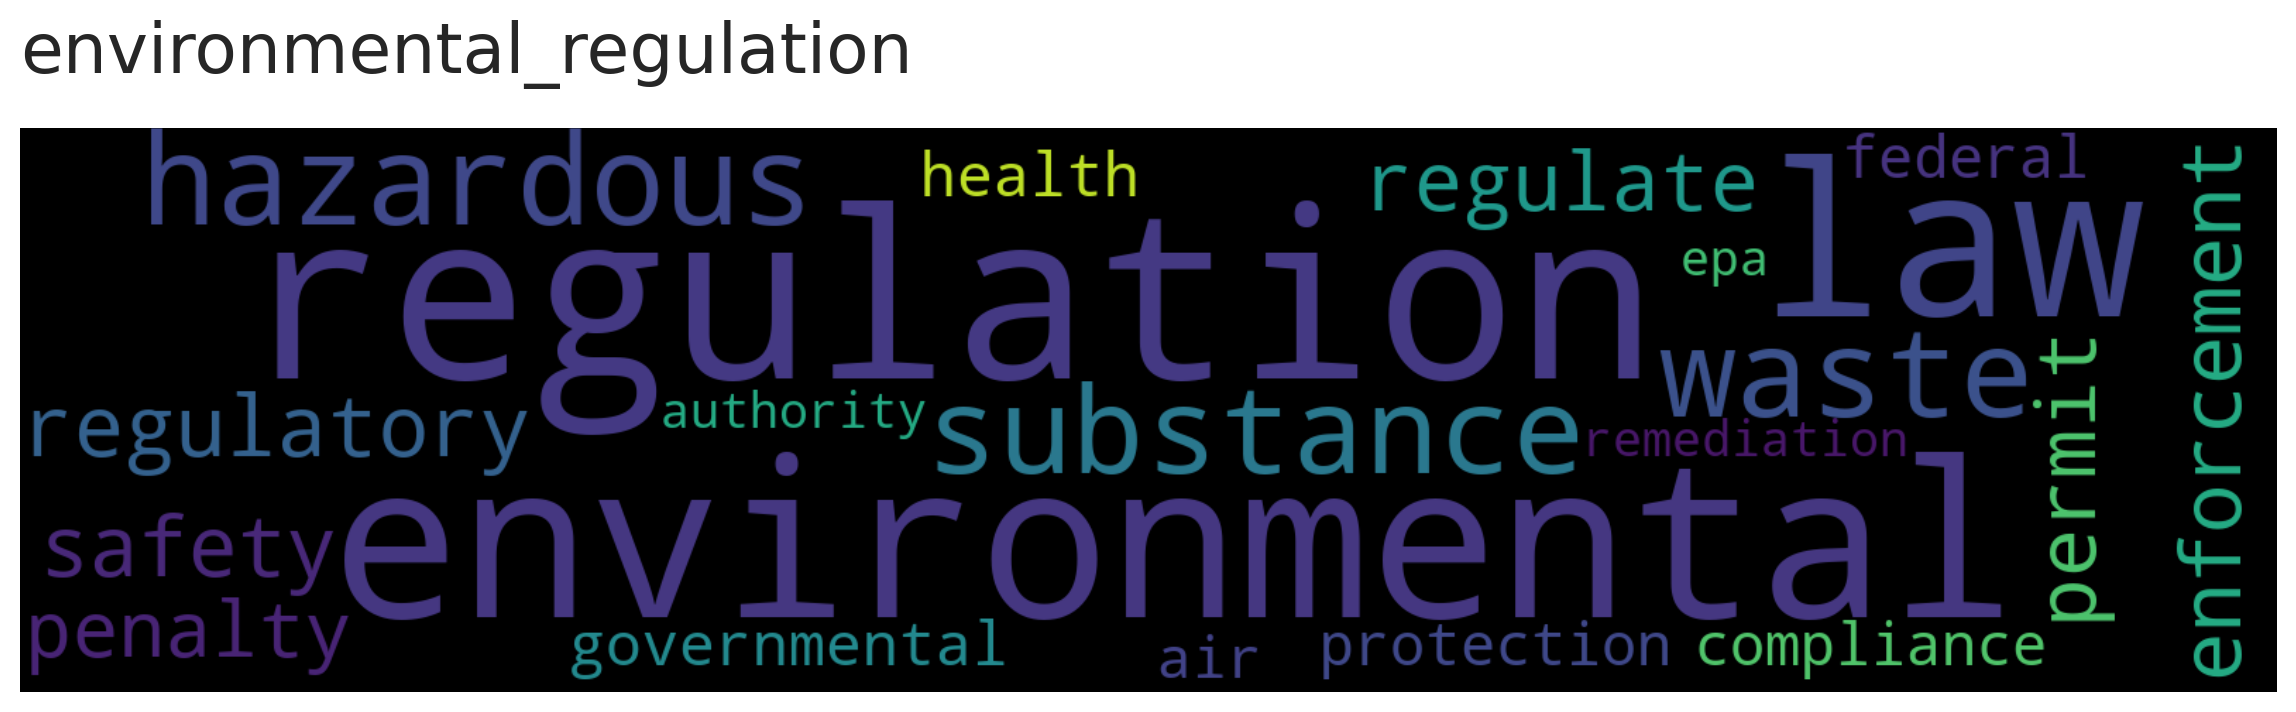

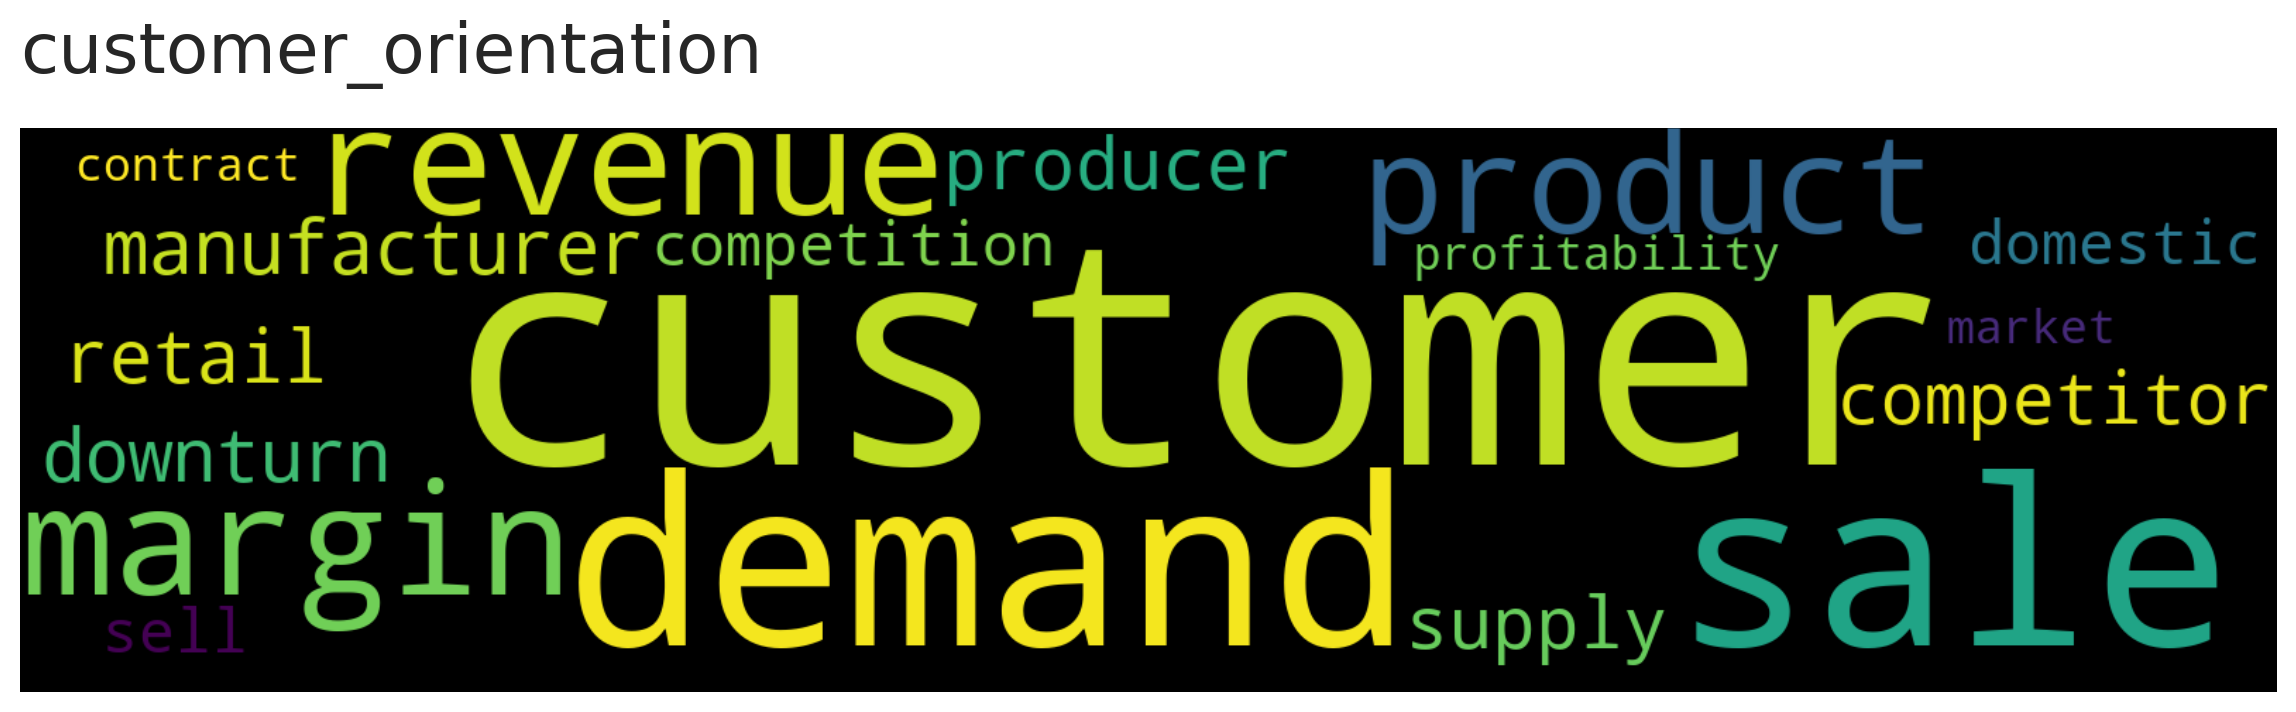

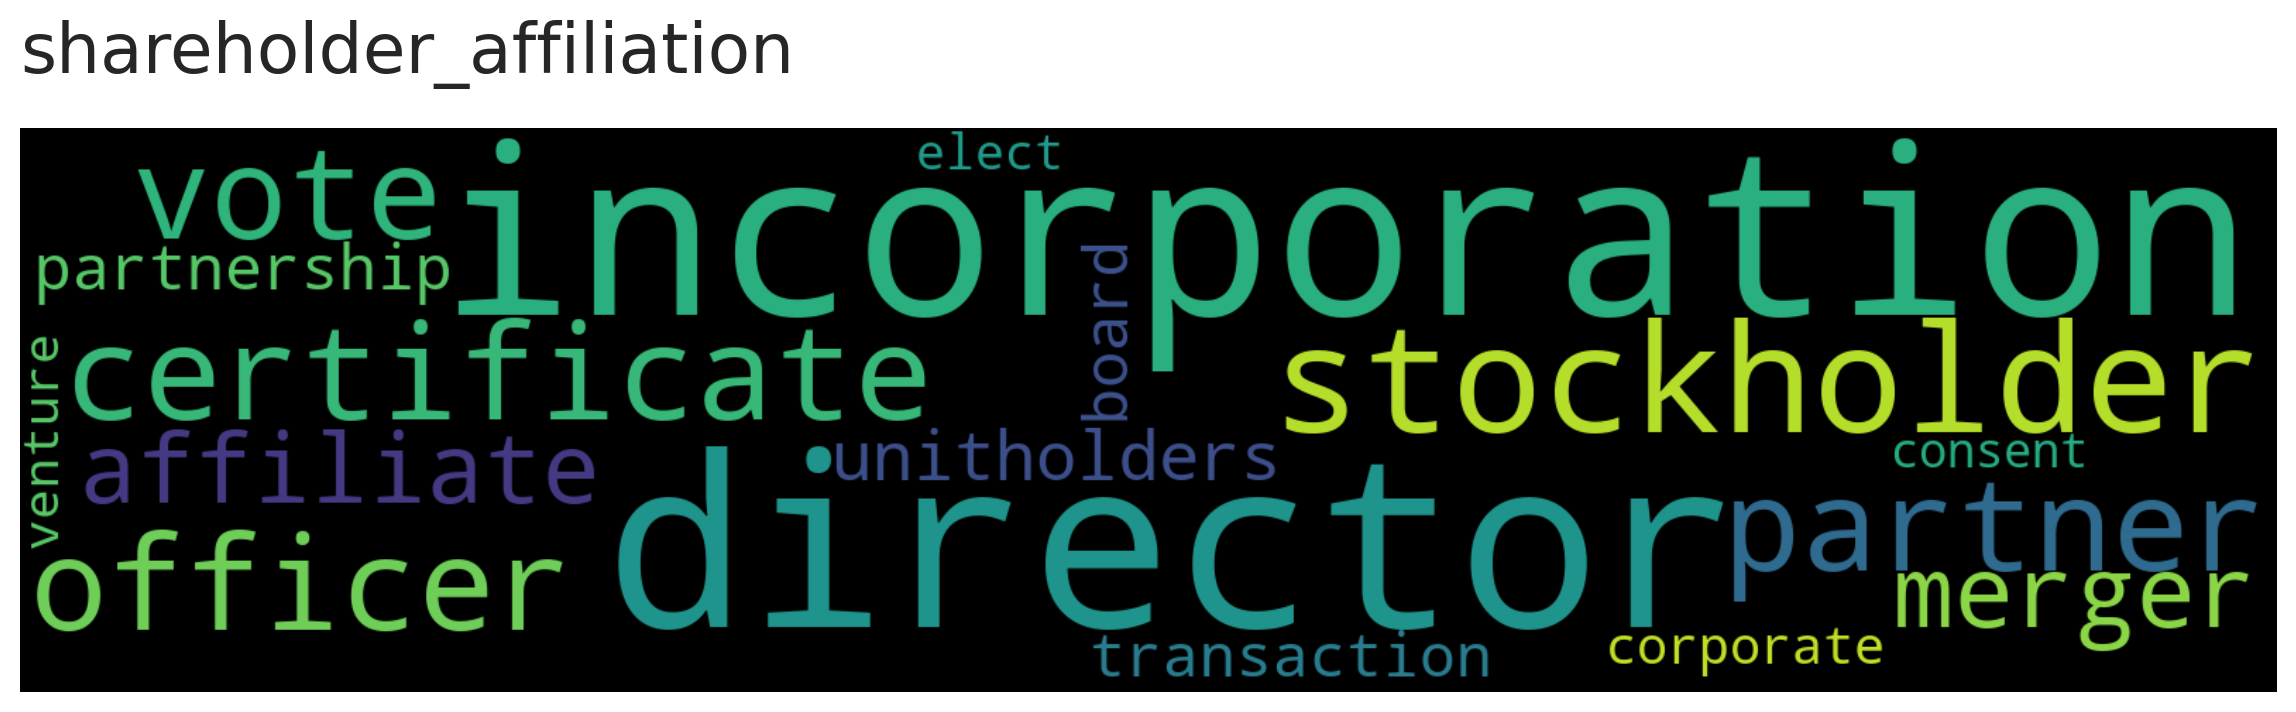

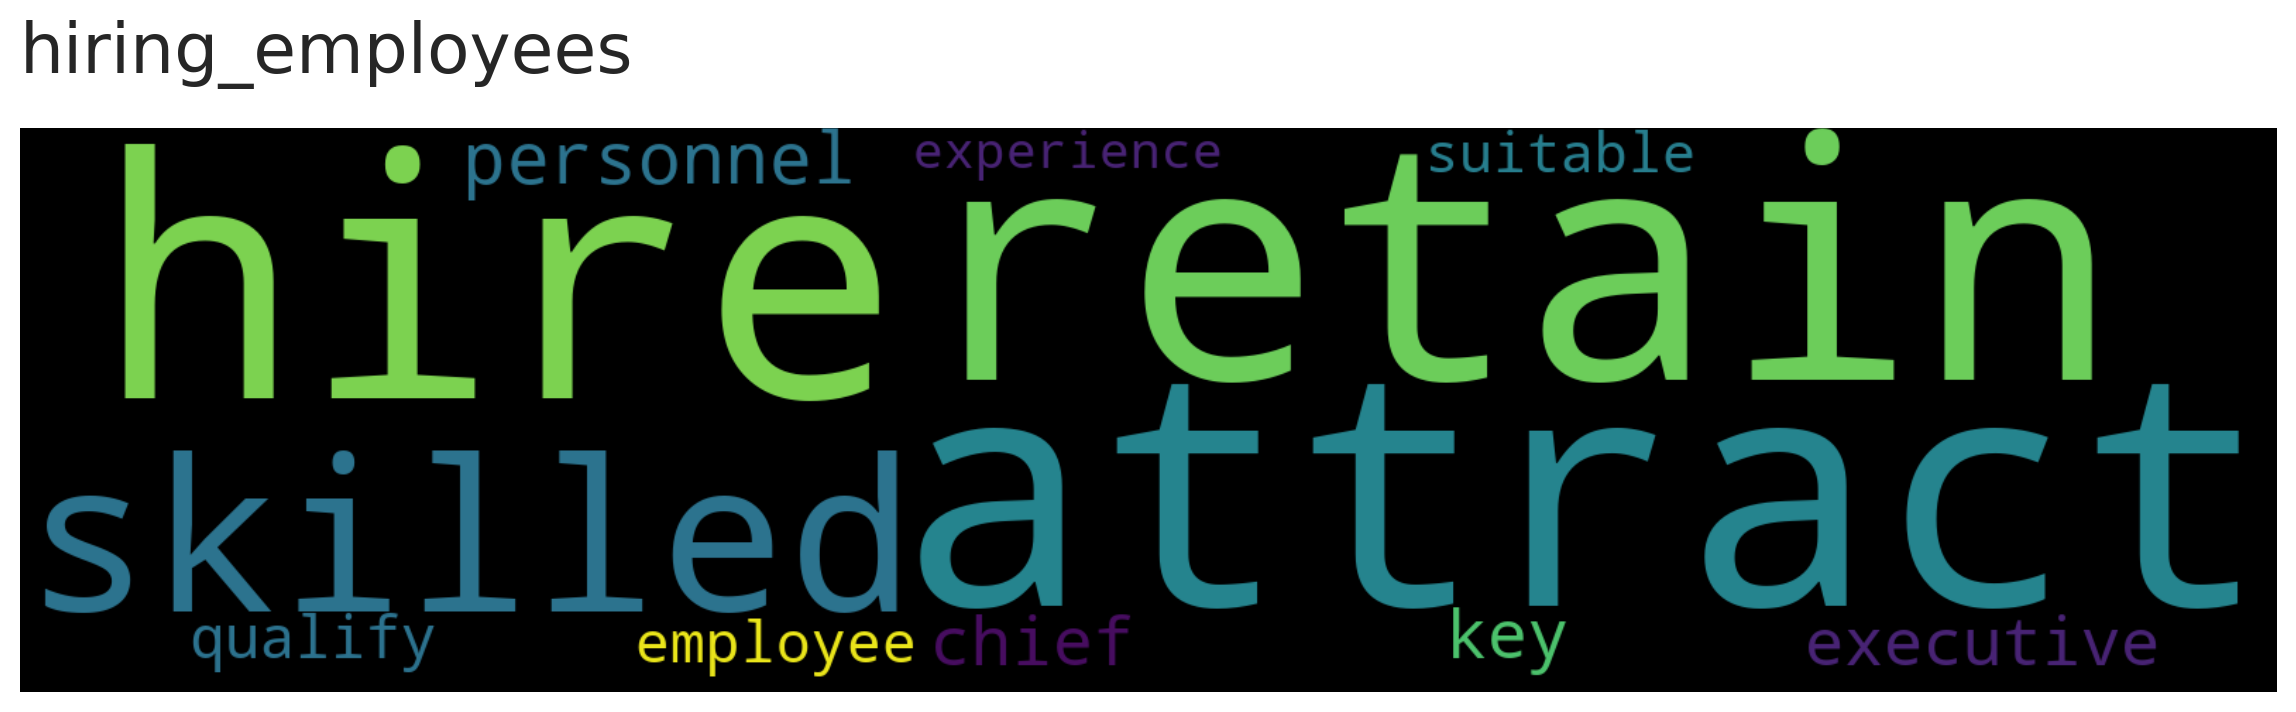

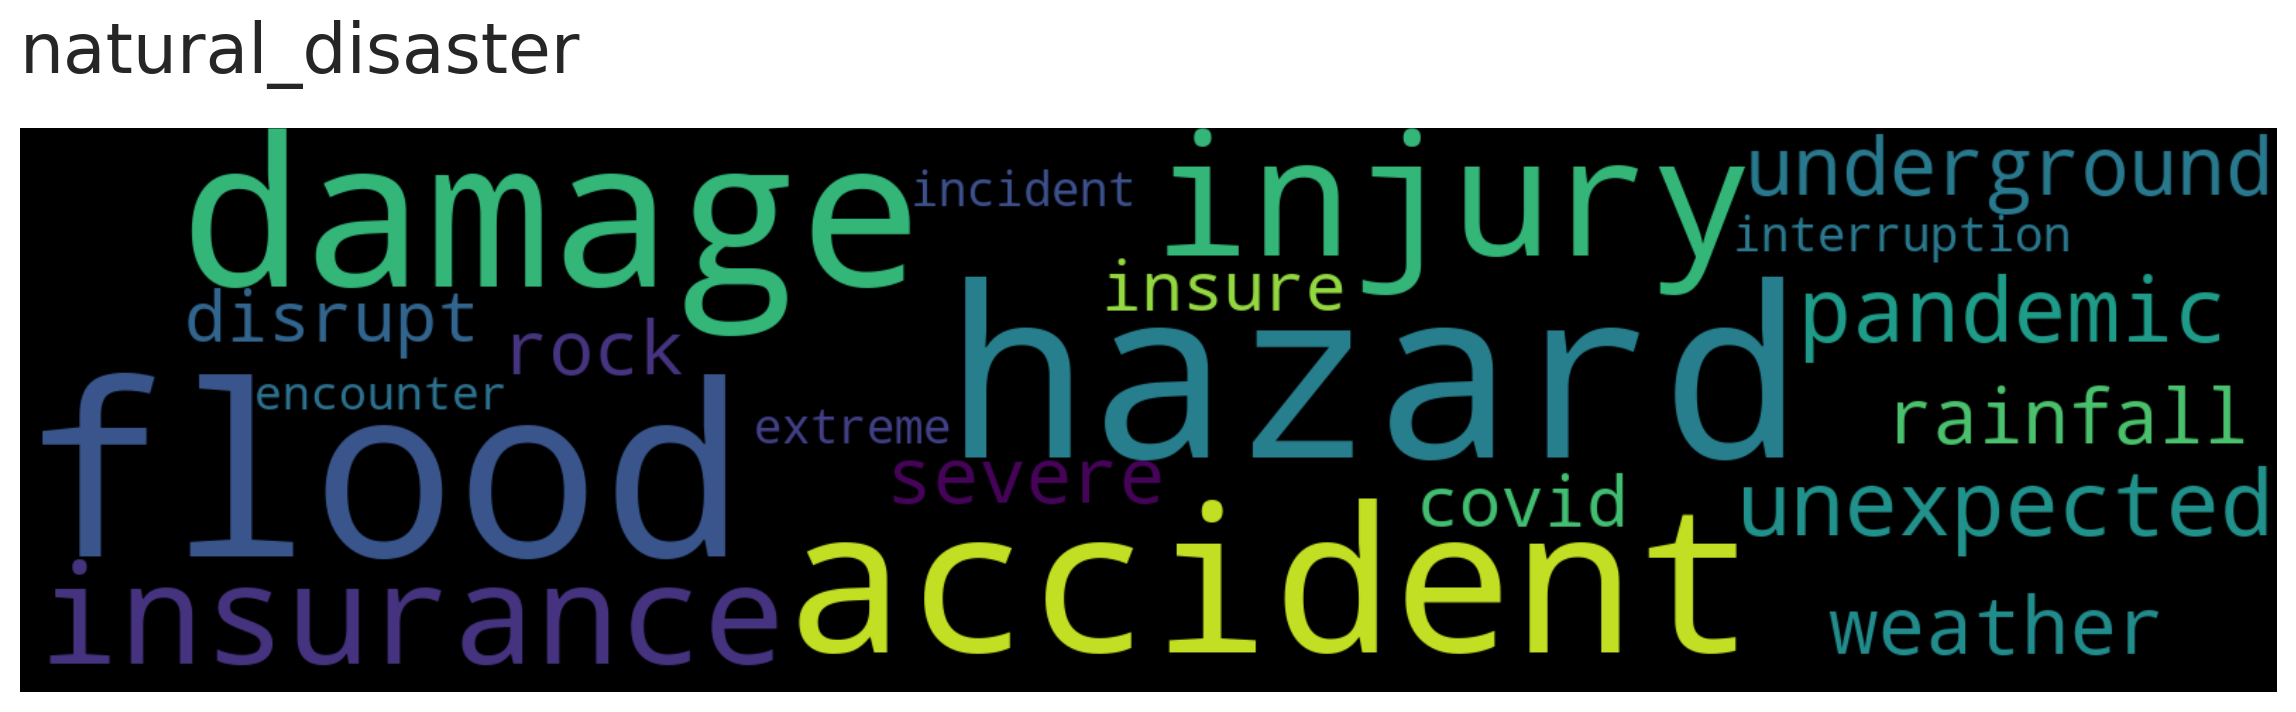

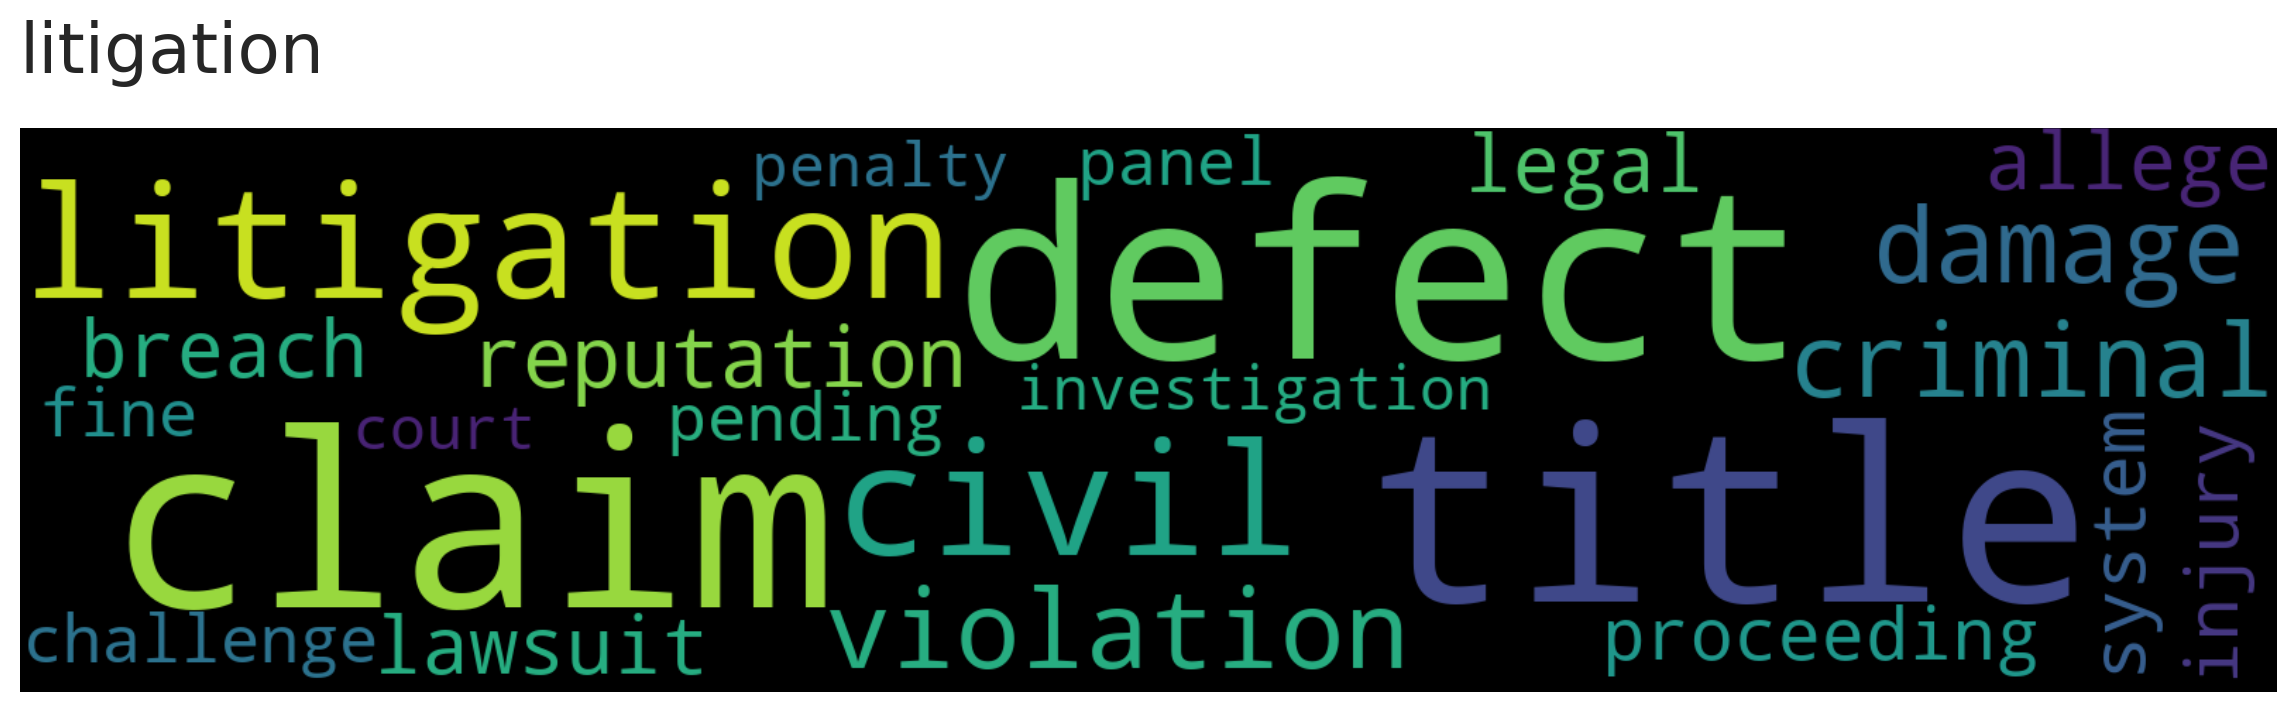

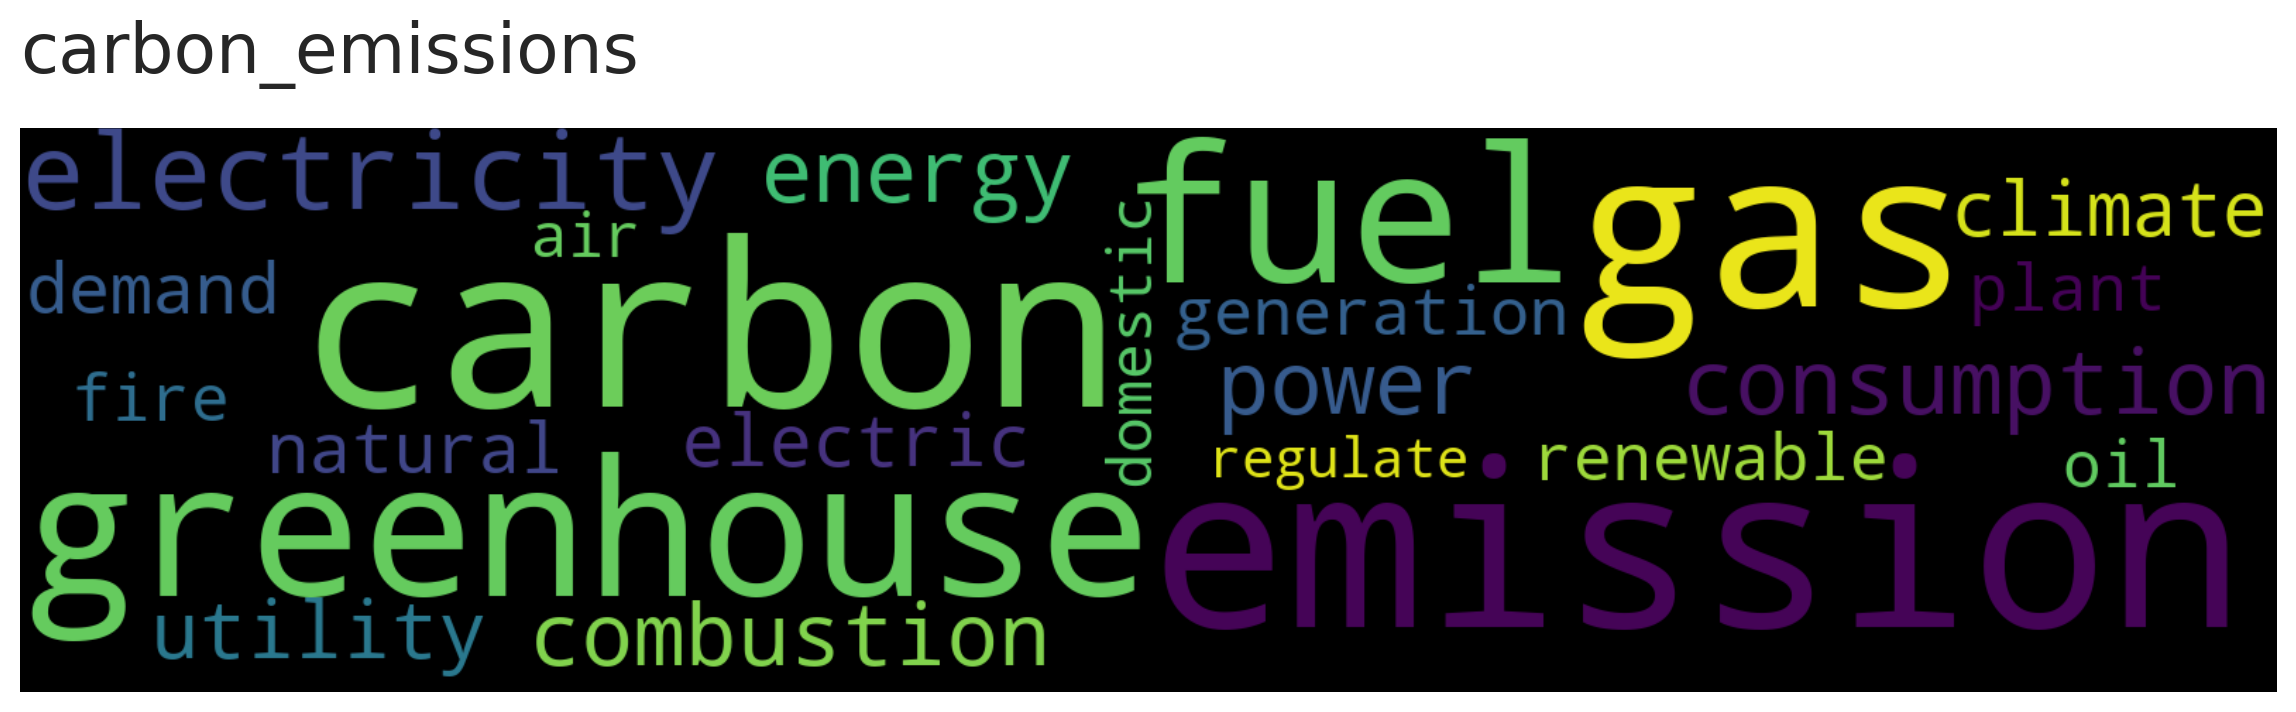

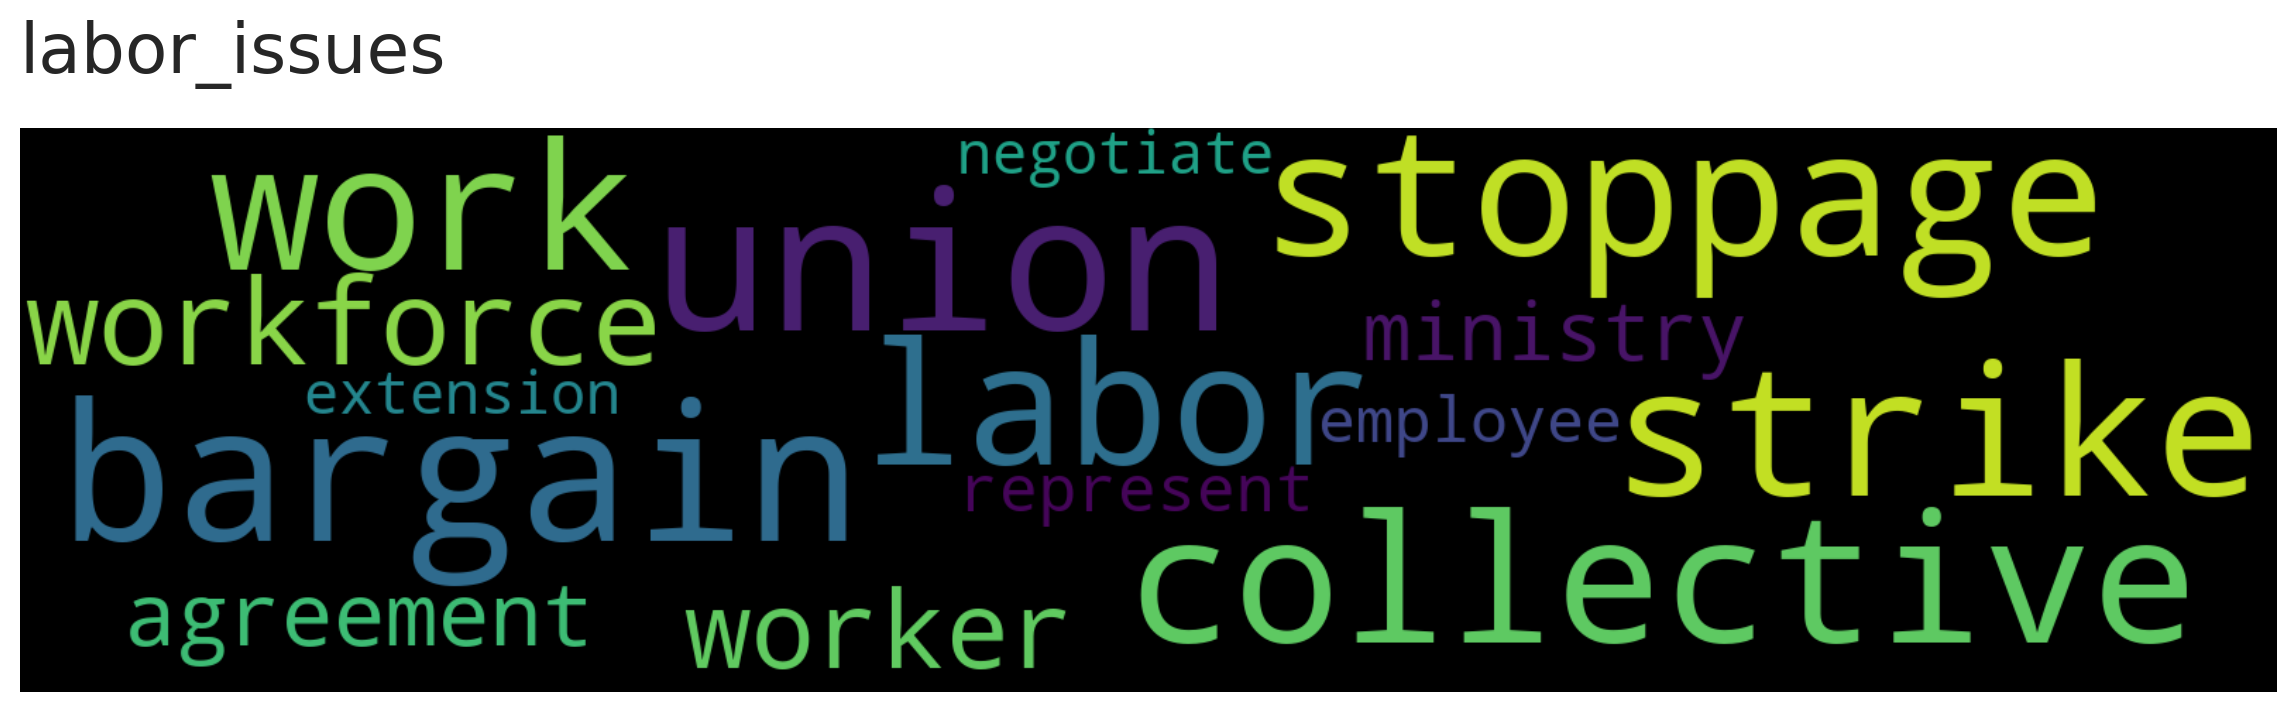

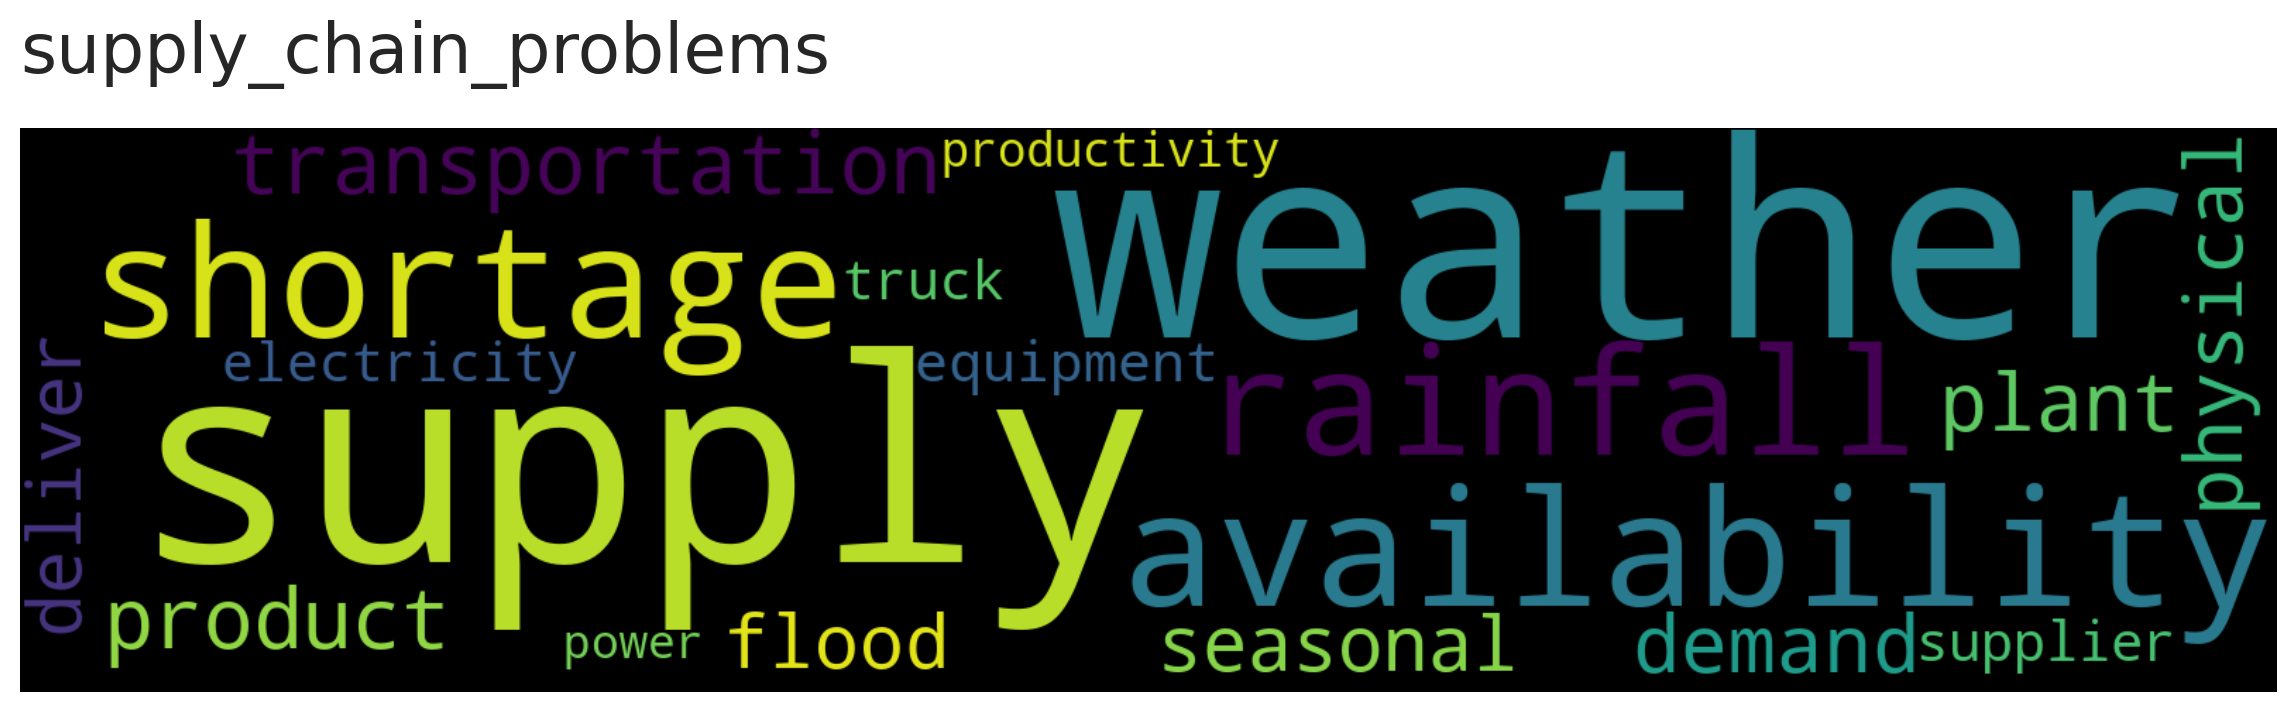

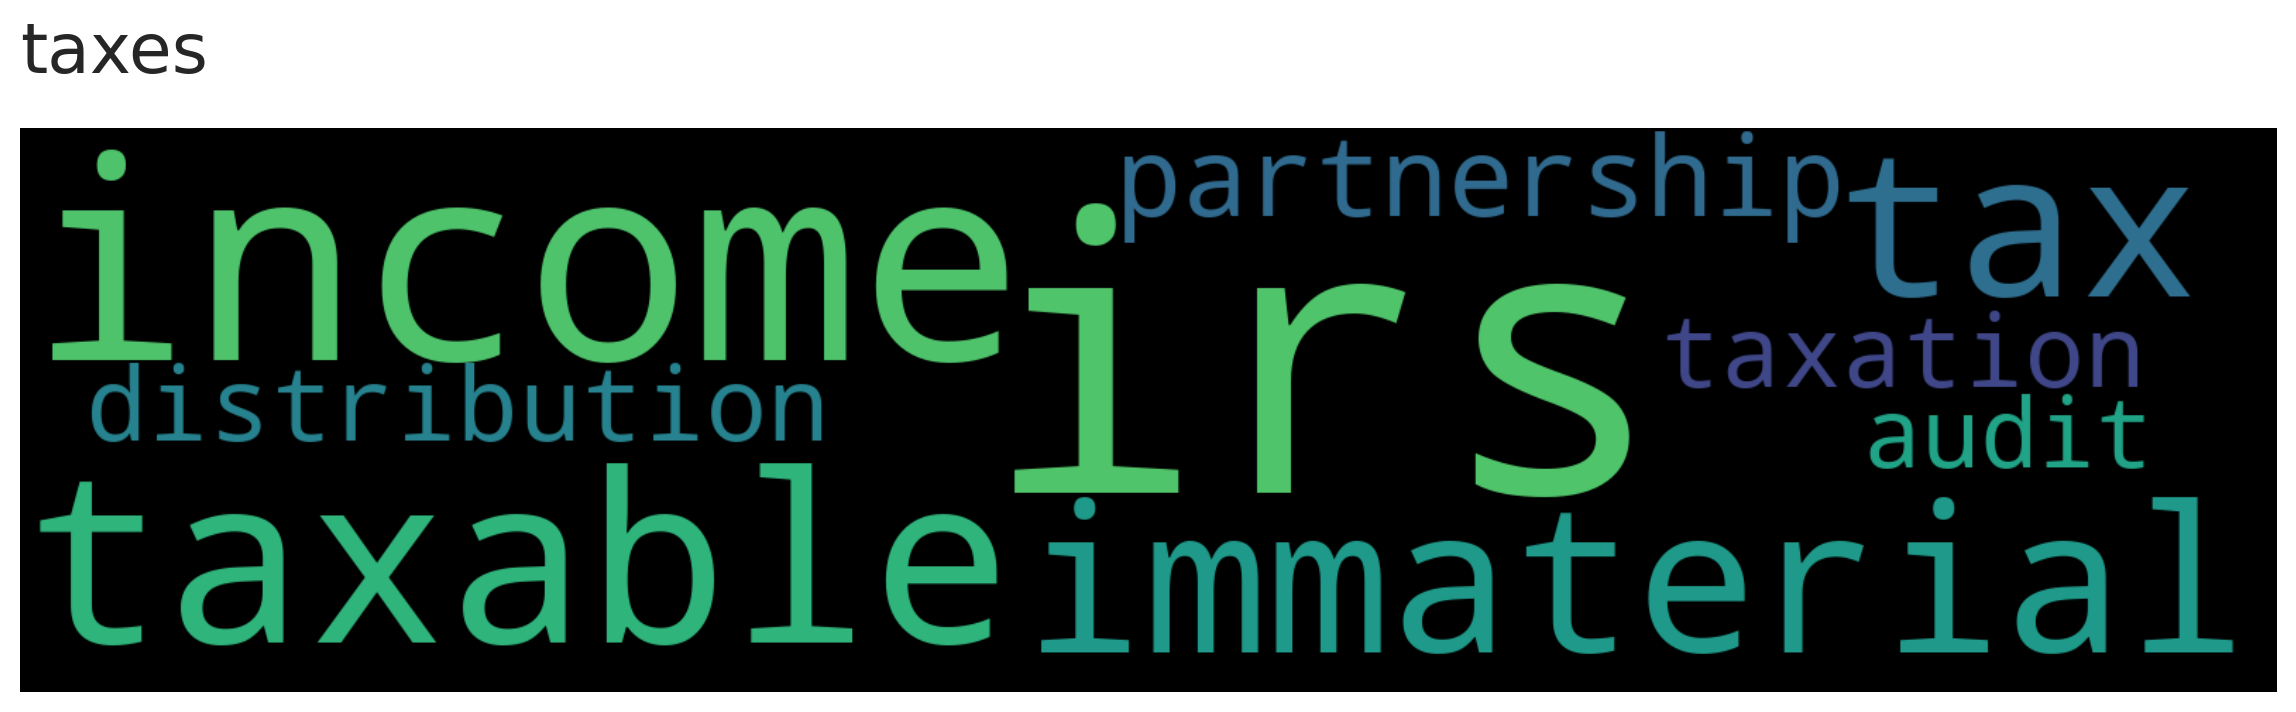

In [7]:
# Re-generate wordclouds for the trimmed topics
for tid in topic_words["topic_num"].unique():
    topic_word_freq = {row.keyword: row.cosine_score for row in 
                            topic_words.loc[topic_words["topic_num"] == tid].itertuples()}
    generate_wordcloud(topic_word_freq, topic_itos_cluster[tid])

### __Top2Vec Cluster Topics Assignment__

In [8]:
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

# Augment topic bags with similar words using FastText embeddings
for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_cluster.items()):
    topic_bags[i] = topic_bags[i] + get_similar_words_fasttext(topic_bags[i] , thresh=0.65)
    topic_bags[i] = list(set(tokenize_text(" ".join(topic_bags[i]))))
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 2 - environmental_regulation): environmental, pollution, penalty, societal, epa, regulatory, permit, legal, waste, safety, authority, governmental, hazardous, remediation, economic, political, regulate, compliance, federal, enforcement, substance, government, air, legislation, health, regulation, state, management, protection, education, law, oversight
Topic ( 4 - customer_orientation): retail, seller, buyer, downturn, product, industry, business, investment, contract, commodity, revenue, market, producer, supplier, margin, demand, sell, profit, sale, competitor, profitability, domestic, manufacture, customer, manufacturer, supply, production, competition
Topic ( 6 - shareholder_affiliation): consent, partner, affiliate, director, business, investment, merger, transaction, agreement, partnership, incorporation, certificate, vote, board, corporation, venture, elect, officer, corporate, shareholder, stockholder, executive, unitholders
Topic ( 8 - hiring_employees): experience, re

In [9]:
predict_topic_fn = t2v_viewer.make_sbert_predictor(topic_bags=topic_bags, model_bert="all-MiniLM-L12-v2")
normalization_fn = lambda ss: [" ".join(tokenize_text(s)) for s in ss]  # Text normalization
df_10k["topic_ids_cluster"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=0.35))

100%|██████████| 367/367 [02:31<00:00,  2.43it/s]


In [21]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for ss, tss in zip(df_test["item1a_sentences"], df_test["topic_ids_cluster"]):
    for s, ts in zip(ss, tss):
        topic_names = []
        for t in ts:
            if t >= 0:
                topic_names.append(topic_itos_cluster[id_map_cluster[t]])
        if topic_names:
            samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

('You should carefully consider the following risk factors, in addition to '
 'those discussed elsewhere in this report, in evaluating our Company, its '
 'business, its industry and prospects.')
- customer_orientation

('In that case, the market price of our securities could decline, and you '
 'could lose part or all of your investment.')
- customer_orientation

('If we are unable to find and mine adequate quantities of gold and silver '
 'ore, it is unlikely that the cash generated from our internal operations '
 'will suffice as a primary source of the liquidity necessary for anticipated '
 'working capital requirements.')
- supply_chain_problems

('In the event of insolvency, liquidation, reorganization, dissolution or '
 'other winding up of the Company, the Companys creditors and preferred '
 'stockholders would be entitled to payment in full out of the Companys assets '
 'before holders of common stock would be entitled to any payment, and the '
 'claims on such assets may exce

### __Pillar Topics (ESG) Assignment__

In [11]:
# Load pillar topic words
topic_words = pd.read_excel(paths.data / "topics" / "MSCI keywords.xlsx", usecols=["Pillar", "Keywords"]) \
                .fillna(method="ffill") \
                .rename(columns={"Keywords": "keyword", "Pillar": "topic_name"}) \
                .apply(lambda x: x.str.lower().str.strip()) \
                .assign(topic_num=lambda x: x["topic_name"].map(lambda t: topic_stoi_pillar[t])) \
                .groupby(["topic_num", "topic_name"]) \
                .agg({"keyword": lambda x: re.split(r",\s|\s", ", ".join(x))}) \
                .reset_index()
topic_bags = topic_words.sort_values("topic_num")["keyword"].values.tolist()

# Augment topic bags with similar words using FastText embeddings
for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_pillar.items()):
    topic_bags[i] = [tn] + topic_bags[i]
    topic_bags[i] = topic_bags[i] + get_similar_words_fasttext(topic_bags[i], top_k=30, thresh=0.7)
    topic_bags[i] = list(set(tokenize_text(" ".join(topic_bags[i]))))
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 0 - environmental): energy, vulnerability, grid, environmental, pollution, model, cap, material, efficiency, alternative, hedge, use, trade, beef, toxic, carcinogen, carbon, renewable, wind, capture, product, cotton, waste, intensive, ecological, water, change, protection, science, property, climate, withdrawal, palm, oil, smog, source, sustainable, marine, hybrid, timber, car, raw, leather, innovation, emission, green, aquaculture, paper, package, agricultural, contamination, smart, depletion, reduction, recycle, land, biodiversity, solar, technology, dairy, build, design, hydro, electric, insurance, impact, ecosystem, management, clean, fragile, electronic, footprint, seafood, biomass, disturbance
Topic ( 1 - social): chemical, environmental, access, physical, condition, abuse, nutrition, development, trade, employment, unsafe, inadequate, demographic, personal, public, product, chain, controversial, harm, safety, labor, employee, injury, fatality, quality, train, social, hum

In [12]:
predict_topic_fn = t2v_viewer.make_sbert_predictor(topic_bags=topic_bags, model_bert="all-MiniLM-L12-v2")
normalization_fn = lambda ss: [" ".join(tokenize_text(s)) for s in ss]  # Text normalization
df_10k["topic_ids_pillar"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=0.3))

100%|██████████| 367/367 [02:23<00:00,  2.56it/s]


In [28]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for ss, tss in zip(df_test["item1a_sentences"], df_test["topic_ids_pillar"]):
    for s, ts in zip(ss, tss):
        topic_names = []
        for t in ts:
            if t >= 0:
                topic_names.append(topic_itos_pillar[id_map_pillar[t]])
        if topic_names:
            samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

('We may also become subject to significant liability for pollution, cave-ins '
 'or hazards, which we cannot insure or which we may elect not to insure.')
- environmental, social

('Furthermore, if our exploration program is successful in discovering '
 'commercially exploitable reserves of valuable minerals, we will require '
 'additional funds in order to place the Leomary into commercial production.')
- environmental

('Thus far, our activities have been primarily limited to organizational '
 'matters, acquiring our mineral claim, obtaining a geology report, '
 'undertaking preliminary exploration work on the Leomary and the preparation '
 'and filing of this registration statement of which this prospectus is a '
 'part.')
- environmental, social

('If we do not find a viable mineral reserve, or if we cannot exploit the '
 'mineral reserve, either because we have insufficient capital resources or '
 'because it is not be economically feasible to do it, we may have to cease '
 'oper

In [14]:
# Free up CUDA memory
del predict_topic_fn

### __Predict if Describing an Action Taken__

In [15]:
predict_action_fn = make_setfit_binary_predictor(str(paths.model / "sentence-transformers/all-MiniLM-L12-v2-actions-aug"))
df_10k["is_action_probas"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_action_fn(ss, return_probas=True))

/home/dogdog/Miniconda3/envs/wharton/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 367/367 [02:27<00:00,  2.49it/s]


In [19]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for row in df_test.itertuples():
    for s, a, t in zip(row.item1a_sentences, row.is_action_probas, row.topic_ids_cluster):
        samples.append((a, s.replace("\n", ""), t))
samples.sort(key=lambda x: x[0], reverse=True)
for s in samples[:100]:
    if s[2][0] >= 0:
        print(f"[ {s[0]:.2f} ] {s[1]} {s[2]}")

[ 0.99 ] We continually seek to expand our operations and coal reserves through acquisitions of other businesses and assets, including leasehold interests. [1]
[ 0.99 ] Since our formation and the acquisition of our predecessor in August 1999, we have expanded our operations by adding and developing mines and coal reserves in existing, adjacent and neighboring properties. [2]
[ 0.98 ] Because of the shortage of trained coal miners in recent years, we have operated certain facilities without full staff and have hired novice miners, who are required to be accompanied by experienced workers as a safety precaution. [3]
[ 0.98 ] We have adopted certain valuation methodologies that may result in a shift of income, gain, loss and deduction between the general partner and the unitholders. [9]
[ 0.98 ] In addition to selling server memory systems, we develop, manufacturer and market a variety of memory products for motherboards that are Intel or AMD processor based. [1]
[ 0.98 ] Federal and sta

In [17]:
# Free up CUDA memory
del predict_action_fn

## __Compute Statistics__

In [62]:
def compute_statistics(row: pd.Series) -> pd.Series:
    ret = {
        "topic_names_cluster": [],
        "topic_names_pillar": [],
        "n_sentences": 0,
        "n_actions": 0,
        "n_sentences_topic_cluster_total": 0,
        "n_actions_topic_cluster_total": 0,
        "n_sentences_topic_pillar_total": 0,
        "n_actions_topic_pillar_total": 0,
    }

    for tn in topic_itos_cluster.values():
        ret[f"n_sentences_topic_cluster_{tn}"] = 0
        ret[f"n_actions_topic_cluster_{tn}"] = 0

    for tn in topic_itos_pillar.values():
        ret[f"n_sentences_topic_pillar_{tn}"] = 0
        ret[f"n_actions_topic_pillar_{tn}"] = 0

    for text, tis_cluster, tis_pillar, proba_action in zip(
        row.item1a_sentences, row.topic_ids_cluster, row.topic_ids_pillar, row.is_action_probas
    ):
        ret["n_sentences"] += 1
        ret["n_actions"] += int(proba_action >= 0.5)

        tns_cluster = []
        for ti in tis_cluster:
            tn = topic_itos_cluster[id_map_cluster[ti]]
            if ti >= 0:
                tns_cluster.append(tn)
                ret[f"n_sentences_topic_cluster_{tn}"] += 1
                ret[f"n_actions_topic_cluster_{tn}"] += int(proba_action >= 0.5)
            else:
                tns_cluster.append("null")
        ret["topic_names_cluster"].append(", ".join(tns_cluster))

        tns_pillar = []
        for ti in tis_pillar:
            tn = topic_itos_pillar[id_map_pillar[ti]]
            if ti >= 0:
                tns_pillar.append(tn)
                ret[f"n_sentences_topic_pillar_{tn}"] += 1
                ret[f"n_actions_topic_pillar_{tn}"] += int(proba_action >= 0.5)
            else:
                tns_pillar.append("null")
        ret["topic_names_pillar"].append(", ".join(tns_pillar))

    for tn in topic_itos_cluster.values():
        ret["n_sentences_topic_cluster_total"] += ret[f"n_sentences_topic_cluster_{tn}"]
        ret["n_actions_topic_cluster_total"] += ret[f"n_actions_topic_cluster_{tn}"]

    for tn in topic_itos_pillar.values():
        ret["n_sentences_topic_pillar_total"] += ret[f"n_sentences_topic_pillar_{tn}"]
        ret["n_actions_topic_pillar_total"] += ret[f"n_actions_topic_pillar_{tn}"]

    return pd.Series(ret)


df_10k_statistics = df_10k.progress_apply(compute_statistics, axis=1)
df_10k_statistics = df_10k.join(df_10k_statistics)
df_10k_statistics.head()

100%|██████████| 367/367 [00:00<00:00, 1355.72it/s]


,symbol,filing_time,item1a,status,keywords,entities,noun_chunks,top8_key,top8_key_scr_all,top8_key_scr_avg,...,n_sentences_topic_cluster_supply_chain_problems,n_actions_topic_cluster_supply_chain_problems,n_sentences_topic_cluster_taxes,n_actions_topic_cluster_taxes,n_sentences_topic_pillar_environmental,n_actions_topic_pillar_environmental,n_sentences_topic_pillar_social,n_actions_topic_pillar_social,n_sentences_topic_pillar_governance,n_actions_topic_pillar_governance
0,abml,2013-12-01,[The Risk Factors below are provided for a pot...,0,"[locate, think, call, lose, assurance, result,...","[oroplata, bylaw article incorporation, minist...","[government regulation, occasional spot shorta...","[accept, devote, hire, express, factor, achiev...","[24.00, 30.00, 3.00, 34.00, 8.00, 33.00, 17.00...",22.88,...,10,2,4,2,15,2,7,2,7,0
1,abml,2015-01-01,[The Risk Factors below are provided for a pot...,0,"[locate, lose, result, estimate, predict, slow...","[oroplata, mineral property, bylaw article inc...","[new mineral interest, material effect, near f...","[hire, factor, share, accept, express, devote,...","[3.00, 8.00, 17.00, 24.00, 34.00, 30.00, 41.00...",25.00,...,6,0,2,1,13,2,6,2,7,0
2,abml,2015-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,0,0,0,0,0,0,0,0,0,0
3,abml,2016-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,0,0,0,0,0,0,0,0,0,0
4,abml,2018-01-01,[Not required..],0,[require],[],[],"[penetrate, pay, perceive, require, permit, pe...","[368.00, 368.00, 368.00, 352.00, 368.00, 368.0...",366.00,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df_10k_statistics \
    .filter(regex=r"symbol|filing_time|n_(sentences|actions)") \
    .to_csv(paths.item1a / "processed" / "item1a_topic_statistics.csv", index=False)

In [63]:
def explode_sentences_attributes(row: pd.Series) -> pd.DataFrame:

    ret = []
    for text, tns_cluster, tns_pillar, proba_action in zip(
        row.item1a_sentences, row.topic_names_cluster, 
        row.topic_names_pillar, row.is_action_probas
    ):
        ret.append(
            {
                "symbol": row.symbol,
                "filing_time": row.filing_time,
                "sentence": text,
                "topic_names_cluster": tns_cluster,
                "topic_names_pillar": tns_pillar,
                "is_action_proba": proba_action,
            }
        )
    return pd.DataFrame(ret)


df_10k_sentences = df_10k_statistics.apply(explode_sentences_attributes, axis=1).tolist()
df_10k_sentences = pd.concat(df_10k_sentences, ignore_index=True)
df_10k_sentences.head()

,symbol,filing_time,sentence,topic_names_cluster,topic_names_pillar,is_action_proba
0,abml,2013-12-01,The Risk Factors below are provided for a pote...,null,null,0.097676
1,abml,2013-12-01,There is a high degree of risk in the purchase...,"customer_orientation, shareholder_affiliation",null,0.063647
2,abml,2013-12-01,"If any of the following risk materialize, it c...",null,null,0.008687
3,abml,2013-12-01,A potential investor must be aware that he or ...,null,null,0.026769
4,abml,2013-12-01,Risks Factors Which May Effect Our Business Be...,shareholder_affiliation,null,0.020413


In [68]:
df_10k_sentences.to_csv(paths.item1a / "processed" / "item1a_topic_sentences.csv", index=False)